# correlation

In [1]:
expname="jra25.gndg_fixsatuorg" ; intyr=30

In [2]:
import warnings
warnings.simplefilter("ignore")
from scipy import stats
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
#
import seaborn as sns

In [3]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [4]:
class Site:
    def DomeF(self):
        sx=14 ; sy=60 # 77°18′59″S 39°42′04″E
        df_lat=-77.3
        df_lon=39.66
        return df_lon,df_lat,sx,sy

In [5]:
def Mon():
    import pandas as pd
    mons = pd.DataFrame({
            "": ["Jan", "Feb", "Mar","Apr","May","Jun",
                     "Jul","Aug","Sep","Oct","Nov","Dec","Jan"],
            })
    return mons
mons=Mon()

In [6]:
df_lon,df_lat,df_x,df_y = Site().DomeF()

## Standard Deviation

### Model results

In [7]:
def std(varin, var):
    df_out = pd.DataFrame.from_dict({
        "std":np.zeros(12)
    }, orient="columns")
    
    indexlist    = mons[""][:12].tolist()
    df_out.index = indexlist
    
    for mm in range(12):
        df                =  varin[varin["Mon"]==mm+1]   
        df_out["std"][mm] = np.nanstd(df[var])

    return df_out.T

In [8]:
loadfile = "T2_anom.npz"
dataset  = np.load(loadfile)
T2       = dataset["T2"]
lon2     = dataset["lon2"]
lat2     = dataset["lat2"]
y        = dataset["y"]
m        = dataset["m"]
d        = dataset["d"]

In [9]:
loadfile = "prcp.npz"
dataset  = np.load(loadfile)
prcp     = dataset["prcp"]

In [10]:
loadfile  = "prcp_d18O_anom.npz"
dataset   = np.load(loadfile)
prcp_d18O = dataset["prcp_d18O"]

In [11]:
loadfile = "sam.npz"
dataset  = np.load(loadfile)
sam      = dataset["sam"][:]

In [12]:
temp_df = T2  [df_x-1, df_y-1, :]
prcp_df = prcp[df_x-1, df_y-1, :]
prcp_d18O_df   = prcp_d18O[df_x-1, df_y-1,:]


In [13]:
df_all = pd.DataFrame.from_dict({
    "Number": np.zeros((len(prcp_d18O_df))),
    "Year": y,
    "Mon" : m,
    "Date": d,
    "d18O": prcp_d18O_df,
    "temp": temp_df     ,
    "prcp": prcp_df     ,
    "sam" : sam         ,
},orient="columns")

In [14]:
df_all = df_all.dropna(how="any")

num = np.zeros(12)
for mm in range(12):
    num[mm] = len(df_all[df_all["Mon"]==mm+1])

In [15]:
prcp_summer = df_all[(df_all["Mon"]<=2)+(df_all["Mon"]>=11)]["prcp"]
prcp_winter = df_all[(df_all["Mon"]>=3)+(df_all["Mon"]<=10)]["prcp"]
stats.mannwhitneyu(prcp_winter, prcp_summer, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=18482064.0, pvalue=1.8452320494557212e-07)

In [16]:
temp_summer = df_all[(df_all["Mon"]<=2)+(df_all["Mon"]>=10)]["temp"]
temp_winter = df_all[(df_all["Mon"]>=3)+(df_all["Mon"]<=9 )]["temp"]
stats.bartlett(temp_winter, temp_summer)

BartlettResult(statistic=873.6390032319258, pvalue=5.2781195084333786e-192)

In [17]:
d18O_summer = df_all[(df_all["Mon"]<=2)+(df_all["Mon"]>=10)]["d18O"]
d18O_winter = df_all[(df_all["Mon"]>=3)+(df_all["Mon"]<=9 )]["d18O"]
stats.bartlett(d18O_winter, d18O_summer)

BartlettResult(statistic=149.16143017723277, pvalue=2.643957422602229e-34)

In [18]:
indexlist = mons[""][:12].tolist()

df_std = pd.DataFrame(data=[map(str,map(int,num)),
                             [n for n in (std(df_all[["Mon","temp"]], "temp").T["std"].values )],
                             [n for n in (std(df_all[["Mon","d18O"]], "d18O").T["std"].values )],
                             [n for n in (std(df_all[["Mon","prcp"]], "prcp").T["std"].values )],
          ], columns=indexlist,
    index=["Number","temp","d18O","prcp"])

display(df_std)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Number,930,847,930,900,930,900,930,930,896,866,893,930
temp,2.769009,4.490685,5.721105,6.856163,8.239761,8.452513,8.572464,7.413277,6.973476,6.205267,4.508381,2.769968
d18O,6.615623,8.336883,9.277513,10.495022,12.287034,12.178008,13.327362,12.314399,12.250507,13.57452,9.469648,6.820874
prcp,0.242969,0.163138,0.111346,0.152383,0.147856,0.201581,0.150638,0.102256,0.087366,0.328713,0.159527,0.287252


In [19]:
def draw_std(df):
    x=np.arange(1,13,1)
    ax  = fig.add_subplot(1,1,1)
    ax.plot(    x,   df["temp"],label="Surface Air Temperature",
            linewidth=1 ,                  color="red")
    ax.scatter( x,   df["temp"],
               marker="o"   ,linewidths=2, c="red"      ,edgecolor="red")
    ax.set_ylim((9-2.5*(9-np.nanstd(df_all[["temp"]])),9))
    ax2=ax.twinx()
    ax2.plot(    x,   df["d18O"],label="$\mathsf{\delta^{18}O_p}$"  ,
            linewidth=1 ,                  color="magenta")
    ax2.scatter( x,   df["d18O"],
               marker="o"   ,linewidths=2, c="magenta"     ,edgecolor="magenta")
    ax2.set_ylim((14-2.5*(14-np.nanstd(df_all[["d18O"]])),14))

    ax.set_xticks(x)
    ax.set_xticklabels(mons[""][:12])

    ax.axhline( y= np.nanstd(df_all[["temp"]]),ls='-' ,linewidth=0.5, color='k')
    ax2.axhline(y= np.nanstd(df_all[["d18O"]]),ls='-' ,linewidth=0.5, color='k')

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, loc='lower center')
    #
    ax.set_ylabel("Surface Air Temperature [\u00b0C]")
    ax2.set_ylabel("$\mathsf{\delta^{18}O_p}$ [\u2030]")

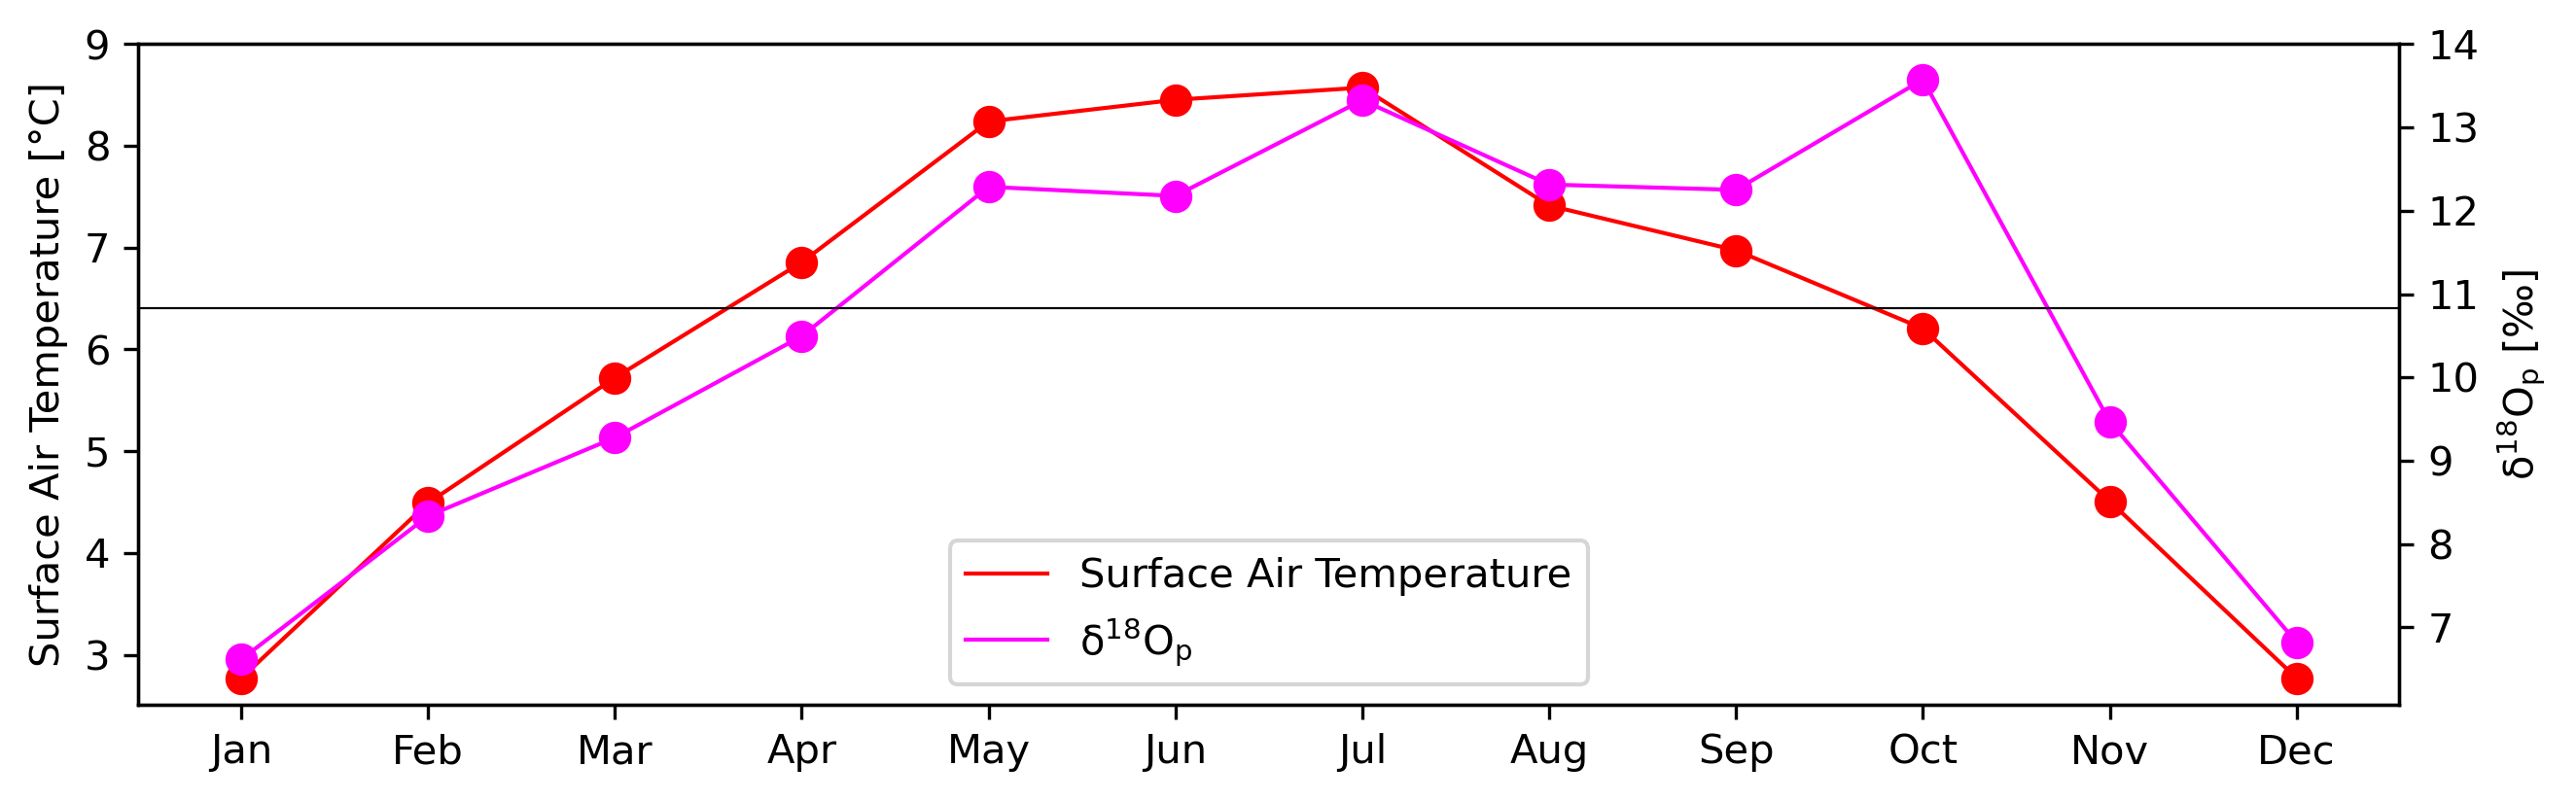

In [20]:
fig = plt.figure(figsize=(10,3)) 
ax = draw_std(df_std.T)
#plt.title("Standard deviation in each @Dome Fuji")
plt.show()
fig.savefig("std.png")

In [21]:
indexlist = mons[""][:12].tolist()
df_std = pd.DataFrame(data=[map(str,map(int,num)),
                             ['{:.2f}'.format(n) for n in (df_std.T["temp"])],
                             ['{:.2f}'.format(n) for n in (df_std.T["d18O"])],
                             ['{:.2f}'.format(n) for n in (df_std.T["prcp"])],
          ], columns=indexlist,
    index=["Number","$\mathsf{SAT}$","$\mathsf{\delta^{18}O_p}$","Precipitation"])

display(df_std)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Number,930,847,930,900,930,900,930,930,896,866,893,930
$\mathsf{SAT}$,2.77,4.49,5.72,6.86,8.24,8.45,8.57,7.41,6.97,6.21,4.51,2.77
$\mathsf{\delta^{18}O_p}$,6.62,8.34,9.28,10.50,12.29,12.18,13.33,12.31,12.25,13.57,9.47,6.82
Precipitation,0.24,0.16,0.11,0.15,0.15,0.20,0.15,0.10,0.09,0.33,0.16,0.29


### Observation

In [22]:
def std_obs(varin,varmean, var):
    df_out = pd.DataFrame.from_dict({
        "std":np.zeros(12)
    }, orient = "columns")
    
    df_out.index = mons[""][:12]
    
    for mm in range(12):
        df                = varin[varin["Mon"]==mm+1]   
        df_out["std"][mm] = np.nanstd(df[var]-varmean[mm] )

    return df_out.T

In [23]:
loadfile  = "sam_jra25.npz"
dataset   = np.load(loadfile)
sam_jra25 = dataset["sam"]

In [24]:
obs_DomeF = np.genfromtxt("obs_DomeF.csv",
                           delimiter=",", # 区切り文字
                           usecols=(0,1,2,3,4,5) # 読み込みたい列
                          )

obs_len          = np.shape(obs_DomeF)[0]
obs_y_df         = obs_DomeF[1:,0]
obs_m_df         = obs_DomeF[1:,1]
obs_d_df         = obs_DomeF[1:,2]
obs_temp_df      = obs_DomeF[1:,3]
obs_prcp_df      = obs_DomeF[1:,4]
obs_prcp_d18O_df = obs_DomeF[1:,5]

obs_dayst  = 31
obs_dayed  = 31 + 365
nanlist    = np.zeros((obs_dayed-obs_len+1))
nanlist[:] = np.nan

obs_y_df         = np.append(obs_y_df        [obs_dayst:obs_dayed], nanlist)
obs_m_df         = np.append(obs_m_df        [obs_dayst:obs_dayed], nanlist)
obs_d_df         = np.append(obs_d_df        [obs_dayst:obs_dayed], nanlist)
obs_temp_df      = np.append(obs_temp_df     [obs_dayst:obs_dayed], nanlist)
obs_prcp_df      = np.append(obs_prcp_df     [obs_dayst:obs_dayed], nanlist)
obs_prcp_d18O_df = np.append(obs_prcp_d18O_df[obs_dayst:obs_dayed], nanlist)

In [25]:
df_obs = pd.DataFrame.from_dict({
    "Number": np.zeros((len(obs_prcp_d18O_df))),
    "Year": obs_y_df,
    "Mon" : obs_m_df,
    "Date": obs_d_df,
    "d18O": obs_prcp_d18O_df,
    "temp": obs_temp_df,
    "prcp": obs_prcp_df,
    "sam" : sam_jra25[((y==2003)&(m>1))+((y==2004)&(m==1))]         ,
},orient="columns")

In [26]:
df_obs  = df_obs.dropna(how="any")

num_obs = np.zeros(12)
for mm in range(12):
    num_obs[mm] = len(df_obs[df_obs["Mon"]==mm+1]) 

In [27]:
df_std_obs = pd.DataFrame(data=[map(str,map(int,num_obs)),
                             std(df_obs[["Mon","temp"]], "temp").T["std"].values ,
                             std(df_obs[["Mon","d18O"]], "d18O").T["std"].values ,
                             std(df_obs[["Mon","prcp"]], "prcp").T["std"].values ,
          ], columns=indexlist,
                           index=["Number","temp","d18O", "prcp"]).T

display(df_std_obs.T)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Number,18,23,31,29,31,30,29,31,29,30,26,26
temp,2.817871,3.786269,5.469704,4.633355,5.201121,4.436374,6.282556,5.049041,3.982384,5.436337,4.838973,3.017638
d18O,4.423473,3.559348,5.735696,4.286407,5.282413,4.249803,5.518803,4.545317,4.618433,5.107739,7.278894,4.50875
prcp,0.20518,0.070527,0.076768,0.04918,0.204859,0.126431,0.171723,0.183569,0.068203,0.047132,0.163275,0.470629


In [28]:
df_std_obs = pd.DataFrame(data=[map(str,map(int,num_obs)),
                                ['{:.2f}'.format(n) for n in (df_std_obs["temp"].values)],
                                ['{:.2f}'.format(n) for n in (df_std_obs["d18O"].values)],
                                ['{:.2f}'.format(n) for n in (df_std_obs["prcp"].values)],                
          ], columns=indexlist,
                          index=["Number","$\mathsf{SAT}$","$\mathsf{\delta^{18}O_p}$", "Precipitation"])

display(df_std_obs)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Number,18,23,31,29,31,30,29,31,29,30,26,26
$\mathsf{SAT}$,2.82,3.79,5.47,4.63,5.20,4.44,6.28,5.05,3.98,5.44,4.84,3.02
$\mathsf{\delta^{18}O_p}$,4.42,3.56,5.74,4.29,5.28,4.25,5.52,4.55,4.62,5.11,7.28,4.51
Precipitation,0.21,0.07,0.08,0.05,0.20,0.13,0.17,0.18,0.07,0.05,0.16,0.47


In [29]:
prcp_summer_obs = df_obs[(df_obs["Mon"]<=2)+(df_obs["Mon"]>=11)]["prcp"]
prcp_winter_obs = df_obs[(df_obs["Mon"]>=3)+(df_obs["Mon"]<=10)]["prcp"]
stats.mannwhitneyu(prcp_winter_obs, prcp_summer_obs, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=13685.0, pvalue=0.04328494500402202)

In [30]:
temp_summer_obs = df_obs[(df_obs["Mon"]<=2)+(df_obs["Mon"]>=10)]["temp"]
temp_winter_obs = df_obs[(df_obs["Mon"]>=3)+(df_obs["Mon"]<=9 )]["temp"]
stats.bartlett(temp_winter_obs, temp_summer_obs)

BartlettResult(statistic=3.505691910263579, pvalue=0.06115829403382094)

In [31]:
d18O_summer_obs = df_obs[(df_obs["Mon"]<=2)+(df_obs["Mon"]>=10)]["d18O"]
d18O_winter_obs = df_obs[(df_obs["Mon"]>=3)+(df_obs["Mon"]<=9 )]["d18O"]
stats.bartlett(d18O_winter_obs, d18O_summer_obs)

BartlettResult(statistic=8.943717868749152, pvalue=0.002784254497742505)

## Non-Correlation test (Non-parametric tests)

In [32]:
p_value=0.05

In [33]:
def spearmanr(varin, var1,var2, p_value=0.05):
    # https://qiita.com/dacciinfo/items/88debe69f9f4e927aafc
    df_out = pd.DataFrame.from_dict({
        "r":np.zeros(12),
        "p":np.zeros(12)
    }, orient="columns")
    df_out.index = mons[""][:12]
    
    for mm in range(12):
        df                               = varin[varin["Mon"]==mm+1]   
        df_out["r"][mm], df_out["p"][mm] = stats.spearmanr(df[var1],df[var2])
    return df_out.T

### Model results

In [34]:
def draw_d18O(df):
    x=np.arange(1,13,1)
    ax  = fig.add_subplot(1,1,1)
    ax.plot(    x,   df["corr_temp"],label="Surface Air Temperature",
            linewidth=1 ,                  color="red")
    ax.scatter( x,   df["corr_temp"],
               marker="o"   ,linewidths=2, c="red"      ,edgecolor="red")
    ax.plot(    x,   df["corr_prcp"],label="Daily Precipitation",
            linewidth=1 ,                  color="darkgreen")
    ax.scatter( x,   df["corr_prcp"],
               marker="o"   ,linewidths=2, c="darkgreen",edgecolor="darkgreen")
    ax.plot(    x,   df["corr_sam" ],label="SAM index"  ,
            linewidth=1 ,                  color="blue")
    ax.scatter( x,   df["corr_sam"],
               marker="o"   ,linewidths=2, c="blue"     ,edgecolor="blue")
    #
    ax.set_xticks(x)
    ax.set_xticklabels(mons[""][:12])
    ax.set_ylim( (-0.6,0.6))
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.axhline(y= 0.0,ls='-' ,linewidth=0.5, color='k')
    ax.axhline(y=-0.2,ls='--',linewidth=0.5, color='k')
    ax.axhline(y=-0.4,ls='--',linewidth=0.5, color='k')
    ax.axhline(y=-0.6,ls='--',linewidth=0.5, color='k')
    ax.axhline(y=-0.8,ls='--',linewidth=0.5, color='k')
    ax.axhline(y= 0.2,ls='--',linewidth=0.5, color='k')
    ax.axhline(y= 0.4,ls='--',linewidth=0.5, color='k')
    ax.axhline(y= 0.6,ls='--',linewidth=0.5, color='k')
    ax.axhline(y= 0.8,ls='--',linewidth=0.5, color='k')
    ax.legend(loc="center")
    #
    ax.set_ylabel("Correlation coefficient")

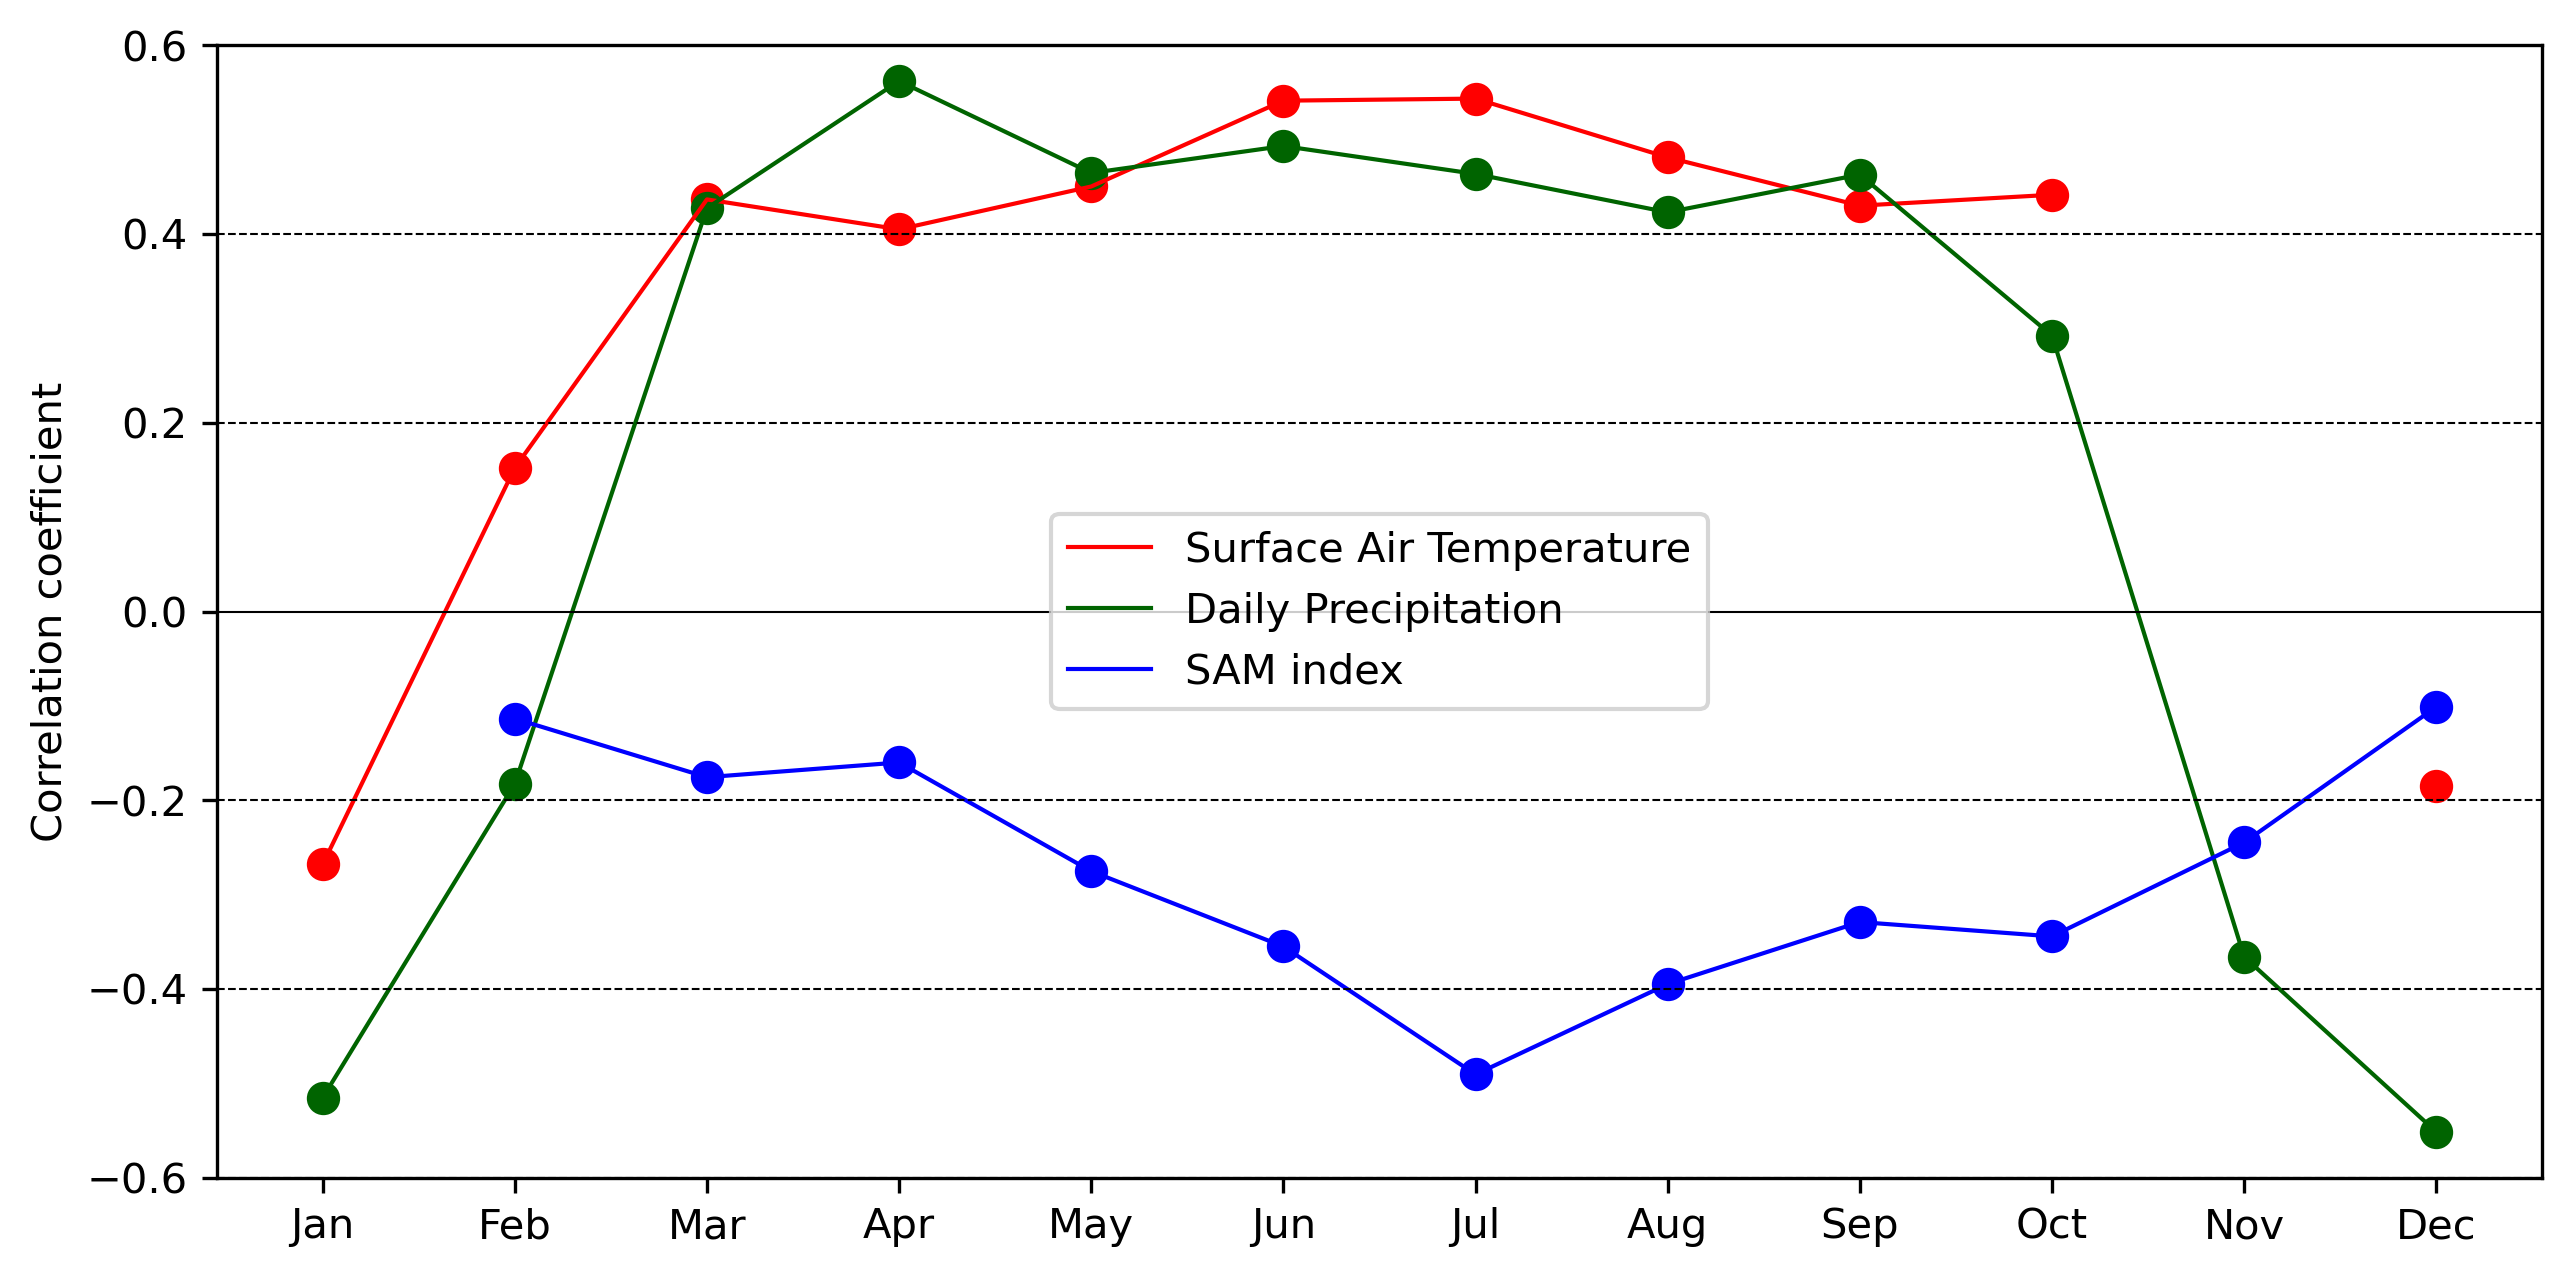

In [35]:
df_spearmanr = pd.DataFrame(
    data=[num,
          spearmanr(df_all[["Mon","d18O","temp"]],"temp","d18O").T["r"].values,
          spearmanr(df_all[["Mon","d18O","temp"]],"temp","d18O").T["p"].values,
          spearmanr(df_all[["Mon","d18O","prcp"]],"prcp","d18O").T["r"].values,
          spearmanr(df_all[["Mon","d18O","prcp"]],"prcp","d18O").T["p"].values,
          spearmanr(df_all[["Mon","d18O","sam" ]],"sam" ,"d18O").T["r"].values,
          spearmanr(df_all[["Mon","d18O","sam" ]],"sam" ,"d18O").T["p"].values
         ],
    index=["Number","corr_temp","p_temp", "corr_prcp", "p_prcp", "corr_sam", "p_sam"],
    columns=mons[""][:12]).T


df_spearmanr["corr_temp"][df_spearmanr["p_temp"]>p_value] = np.nan
df_spearmanr["corr_prcp"][df_spearmanr["p_prcp"]>p_value] = np.nan
df_spearmanr["corr_sam" ][df_spearmanr["p_sam" ]>p_value] = np.nan

fig = plt.figure(figsize=(10,5)) 
ax = draw_d18O(df_spearmanr)
#plt.title("Spearman's correlation coefficient with $\mathsf{\delta^{18}O_p}$ in each month @Dome Fuji")
plt.show()
fig.savefig("correlation_spearman.png")

In [36]:
df_spearmanr = pd.DataFrame(
    data=[map(str,map(int,num)),   
          ['{:.2f}'.format(n) for n in (df_spearmanr["corr_temp"])],
          ['{:.2E}'.format(n) for n in (df_spearmanr["p_temp"])],
          ['{:.2f}'.format(n) for n in (df_spearmanr["corr_prcp"])],
          ['{:.2E}'.format(n) for n in (df_spearmanr["p_prcp"])],
          ['{:.2f}'.format(n) for n in (df_spearmanr["corr_sam"])],
          ['{:.2E}'.format(n) for n in (df_spearmanr["p_sam"])],
    ],
    index=["Number","$R_\mathsf{{SAT}}$","$p_\mathsf{{SAT}}$", "$R_\mathsf{{P}}$", "$p_\mathsf{{P}}$", "$R_\mathsf{{SAM}}$", "$p_\mathsf{{SAM}}$"],
    columns=mons[""][:12]).T

display(df_spearmanr.T)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Number,930,847,930,900,930,900,930,930,896,866,893,930
$R_\mathsf{{SAT}}$,-0.27,0.15,0.44,0.41,0.45,0.54,0.54,0.48,0.43,0.44,nan,-0.18
$p_\mathsf{{SAT}}$,9.31E-17,8.60E-06,1.36E-44,7.50E-37,1.17E-47,1.15E-69,1.30E-72,4.35E-55,1.20E-41,1.18E-42,8.53E-02,1.45E-08
$R_\mathsf{{P}}$,-0.52,-0.18,0.43,0.56,0.46,0.49,0.46,0.42,0.46,0.29,-0.37,-0.55
$p_\mathsf{{P}}$,3.48E-64,8.81E-08,1.31E-42,3.99E-76,5.10E-51,2.25E-56,9.22E-51,1.10E-41,8.14E-49,1.52E-18,1.17E-29,4.56E-75
$R_\mathsf{{SAM}}$,nan,-0.11,-0.18,-0.16,-0.28,-0.35,-0.49,-0.39,-0.33,-0.34,-0.24,-0.10
$p_\mathsf{{SAM}}$,8.85E-02,9.43E-04,7.20E-08,1.43E-06,1.30E-17,4.23E-28,1.91E-57,4.91E-36,4.71E-24,1.74E-25,1.23E-13,2.05E-03


### Observation

In [37]:
df_spearmanr_obs = pd.DataFrame(
    data=[map(str,map(int,num_obs)),
          ['{:.2f}'.format(n) for n in (spearmanr(df_obs[["Mon","d18O","temp"]],"temp","d18O").T["r"].values )],
          spearmanr(df_obs[["Mon","d18O","temp"]],"temp","d18O").T["p"].values,
          ['{:.2f}'.format(n) for n in (spearmanr(df_obs[["Mon","d18O","prcp"]],"prcp","d18O").T["r"].values )],
          spearmanr(df_obs[["Mon","d18O","prcp"]],"prcp","d18O").T["p"].values,
          ['{:.2f}'.format(n) for n in (spearmanr(df_obs[["Mon","d18O","sam" ]],"sam" ,"d18O").T["r"].values )],
          spearmanr(df_obs[["Mon","d18O","sam" ]],"sam" ,"d18O").T["p"].values
    ],
    index=["Number","$R_\mathsf{{SAT}}$","$p_\mathsf{{SAT}}$", "$R_\mathsf{{P}}$", "$p_\mathsf{{P}}$", "$R_\mathsf{{SAM}}$", "$p_\mathsf{{SAM}}$"],
    columns=mons[""][:12]).T

df_spearmanr_obs["$R_\mathsf{{SAT}}$"][df_spearmanr_obs["$p_\mathsf{{SAT}}$"]>p_value] = np.nan
df_spearmanr_obs["$R_\mathsf{{P}}$"  ][df_spearmanr_obs["$p_\mathsf{{P}}$"  ]>p_value] = np.nan
df_spearmanr_obs["$R_\mathsf{{SAM}}$"][df_spearmanr_obs["$p_\mathsf{{SAM}}$"]>p_value] = np.nan

df_spearmanr_obs["$p_\mathsf{{SAT}}$"] = ['{:.2E}'.format(n) for n in (df_spearmanr_obs["$p_\mathsf{{SAT}}$"])]
df_spearmanr_obs["$p_\mathsf{{P}}$"  ] = ['{:.2E}'.format(n) for n in (df_spearmanr_obs["$p_\mathsf{{P}}$"  ])]
df_spearmanr_obs["$p_\mathsf{{SAM}}$"] = ['{:.2E}'.format(n) for n in (df_spearmanr_obs["$p_\mathsf{{SAM}}$"])]
display(df_spearmanr_obs.T)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Number,18,23,31,29,31,30,29,31,29,30,26,26
$R_\mathsf{{SAT}}$,0.65,0.56,0.47,0.40,NaN,0.46,0.60,0.57,0.44,0.66,0.82,NaN
$p_\mathsf{{SAT}}$,3.70E-03,5.94E-03,7.15E-03,3.13E-02,7.66E-01,1.02E-02,5.29E-04,8.83E-04,1.72E-02,8.03E-05,2.92E-07,6.26E-02
$R_\mathsf{{P}}$,NaN,NaN,NaN,0.43,0.59,0.77,0.73,0.59,0.46,NaN,NaN,NaN
$p_\mathsf{{P}}$,5.02E-01,1.05E-01,5.97E-01,1.97E-02,4.91E-04,5.29E-07,7.17E-06,5.10E-04,1.26E-02,3.27E-01,9.02E-02,3.44E-01
$R_\mathsf{{SAM}}$,NaN,NaN,-0.57,NaN,NaN,NaN,NaN,NaN,-0.51,NaN,-0.57,NaN
$p_\mathsf{{SAM}}$,2.91E-01,6.71E-02,7.54E-04,5.62E-01,6.48E-01,1.26E-01,1.03E-01,1.64E-01,4.82E-03,2.04E-01,2.17E-03,1.35E-01


Kanon Kino (kanon[at]aori.u-tokyo.ac.jp)